In [133]:
# %%
# =========================
# Imports
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GroupKFold,
    RandomizedSearchCV,
    train_test_split,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestRegressor

plt.style.use("seaborn-v0_8")

## Configuration and data Load

In [134]:
# %%
# =========================
# Configuration and data loading
# =========================

PATH = Path(r"C:\Users\kfq6\Documents\Data\Sammedag_master_HbA1c_Features.xlsx")
ID_COL = "DW_EK_Borger"
TARGET_COL = "HbA1c_next"

# Columns to drop immediately
cols_to_drop_initial = [
    "LABmean__p_albumin_g_l",
    "year_next",
    "anchor_date_next",
    "delta_years_to_next",
    "HbA1c_band",
    "HbA1c_band_lt53",
    "HbA1c_band_53_69",
    "HbA1c_band_ge70",
    "HbA1c_prev_high",
    "HbA1c_prev_missing",
]

# Load data
df = pd.read_excel(PATH)
df = df.drop(columns=cols_to_drop_initial, errors="ignore")

# Keep only rows with available target
df_model = df.dropna(subset=[TARGET_COL]).copy()

print("Data after dropping missing target:")
df_model.info()

Data after dropping missing target:
<class 'pandas.core.frame.DataFrame'>
Index: 1384 entries, 0 to 2062
Data columns (total 33 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   DW_EK_Borger                                 1384 non-null   int64         
 1   sex                                          1384 non-null   object        
 2   age                                          1384 non-null   float64       
 3   diagnosis                                    1384 non-null   object        
 4   comp_eye                                     1384 non-null   int64         
 5   comp_renal                                   1384 non-null   int64         
 6   comp_neuro                                   1384 non-null   int64         
 7   comp_periph                                  1384 non-null   int64         
 8   comp_foot                                    13

# Missingness function and overview

In [135]:

def missing_table(df_in: pd.DataFrame) -> pd.DataFrame:
    missing_count = df_in.isna().sum()
    missing_percent = (missing_count / len(df_in)) * 100
    tbl = pd.DataFrame({
        "Missing Count": missing_count,
        "Missing %": missing_percent.round(2),
    })
    return tbl[tbl["Missing Count"] > 0].sort_values("Missing %", ascending=False)


missing_tbl = missing_table(df_model)
print("\nMissingness overview (top 20):")
display(missing_tbl.head(20))



Missingness overview (top 20):


,Missing Count,Missing %
HbA1c_slope_prev_year,684,49.42
HbA1c_CV_prev_year,684,49.42
HbA1c_MAC_prev_year,684,49.42
HbA1c_prev,680,49.13
LABmean__b_haemoglobin_mmol_l,353,25.51
who_score,308,22.25
LABmean__u_albumin_kreatinin_ratio_mg_g,306,22.11
LABmean__p_vitamin_b12_pmol_l,4,0.29


## Feature Defintion and orgninising

In [136]:
# Candidate numeric clinical / lab / temporal features
numerical_candidate = [
    "age",
    "n_visits_in_window",
    "who_score",
    "LABmean__b_haemoglobin_mmol_l",
    "LABmean__egfr_1_73m2_ckd_epi_ml_min",
    "LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol",
    "LABmean__p_kalium_mmol_l",
    "LABmean__p_kolesterol_hdl_mmol_l",
    "LABmean__p_kolesterol_ldl_mmol_l",
    "LABmean__p_kolesterol_mmol_l",
    "LABmean__p_kreatinin_umol_l",
    "LABmean__p_natrium_mmol_l",
    # Watch naming here: adjust if your column is spelled slightly differently
    "LABmean__p_triglycerid_mmol_l",
    "LABmean__p_vitamin_b12_pmol_l",
    "LABmean__u_albumin_kreatinin_ratio_mg_g",
    "HbA1c_slope_prev_year",
    "HbA1c_CV_prev_year",
    "HbA1c_MAC_prev_year",
    "HbA1c_prev", 
]

# Binary complication flags (treated as numeric)
binary_comp_cols = [
    "comp_eye",
    "comp_renal",
    "comp_neuro",
    "comp_periph",
    "comp_foot",
    "comp_multiple",
    "comp_uns",
]

numerical_candidate = numerical_candidate + binary_comp_cols

# Categorical features to one-hot encode
categorical_candidate = ["sex", "diagnosis", "has_who_in_year"]

# Columns that should never be used as features
non_feature_cols = [ID_COL, "anchor_date", TARGET_COL]

# Actual columns in the dataframe
all_cols = df_model.columns.tolist()

# Filter candidate lists to only keep existing, allowed columns
numerical_cols = [
    c for c in numerical_candidate
    if c in all_cols and c not in non_feature_cols
]
categorical_cols = [
    c for c in categorical_candidate
    if c in all_cols and c not in non_feature_cols
]

feature_cols = sorted(set(numerical_cols + categorical_cols))

print("\nNumerical columns used:")
print(numerical_cols)

print("\nCategorical columns used:")
print(categorical_cols)

missing_in_df = set(numerical_candidate + categorical_candidate) - set(all_cols)
if missing_in_df:
    print("\nNOTE: These candidate features were NOT found in df_model and will be ignored:")
    print(missing_in_df)


Numerical columns used:
['age', 'n_visits_in_window', 'who_score', 'LABmean__b_haemoglobin_mmol_l', 'LABmean__egfr_1_73m2_ckd_epi_ml_min', 'LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol', 'LABmean__p_kalium_mmol_l', 'LABmean__p_kolesterol_hdl_mmol_l', 'LABmean__p_kolesterol_ldl_mmol_l', 'LABmean__p_kolesterol_mmol_l', 'LABmean__p_kreatinin_umol_l', 'LABmean__p_natrium_mmol_l', 'LABmean__p_triglycerid_mmol_l', 'LABmean__p_vitamin_b12_pmol_l', 'LABmean__u_albumin_kreatinin_ratio_mg_g', 'HbA1c_slope_prev_year', 'HbA1c_CV_prev_year', 'HbA1c_MAC_prev_year', 'HbA1c_prev', 'comp_eye', 'comp_renal', 'comp_neuro', 'comp_periph', 'comp_foot', 'comp_multiple', 'comp_uns']

Categorical columns used:
['sex', 'diagnosis', 'has_who_in_year']


## train test split

In [137]:
unique_ids = df_model[ID_COL].unique()

train_ids, test_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    random_state=42,
)

train_df = df_model[df_model[ID_COL].isin(train_ids)].copy()
test_df  = df_model[df_model[ID_COL].isin(test_ids)].copy()

print(f"\nTrain patients: {train_df[ID_COL].nunique()}, rows: {len(train_df)}")
print(f"Test patients : {test_df[ID_COL].nunique()}, rows: {len(test_df)}")

X_train = train_df[feature_cols]
y_train = train_df[TARGET_COL]

X_test  = test_df[feature_cols]
y_test  = test_df[TARGET_COL]

groups_train = train_df[ID_COL]
groups_test  = test_df[ID_COL]  



Train patients: 476, rows: 972
Test patients : 204, rows: 412


## Scaling, one hot encode

In [138]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

# Baseline models

 Baselines are simple reference predictors that do NOT use the full model.
Their purpose:
   - Provide a minimum standard the ML model must beat.
   - Help interpret the value of the complex model.

 Baseline 1: "global mean"
   - Predict the mean HbA1c_next from the TRAIN set for every test patient.
   - Interpretation: "What if we ignored all features and just predicted
     the average HbA1c_next for everyone?"

 Baseline 2: "previous HbA1c"
   - For test patients who have HbA1c_prev available, predict HbA1c_next
     as simply equal to HbA1c_prev.
   - Interpretation: "What if we just use last year's HbA1c as our prediction?"

In [139]:
# Baseline 1: predict global mean HbA1c_next from TRAIN set
baseline_mean = y_train.mean()
y_pred_mean = np.full_like(y_test, fill_value=baseline_mean, dtype=float)

rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))
mae_mean = mean_absolute_error(y_test, y_pred_mean)

print("\n--- BASELINE: Predict TRAIN mean HbA1c_next ---")
print(f"RMSE (mean): {rmse_mean:.2f}")
print(f"MAE  (mean): {mae_mean:.2f}")

# Baseline 2: predict previous year's HbA1c where available
hba1c_prev_test = test_df["HbA1c_prev"]
mask_prev = hba1c_prev_test.notna()

baseline_prev = hba1c_prev_test[mask_prev]
y_test_prev = y_test[mask_prev]

rmse_prev = np.sqrt(mean_squared_error(y_test_prev, baseline_prev))
mae_prev = mean_absolute_error(y_test_prev, baseline_prev)

print("\n--- BASELINE: Predict HbA1c_prev (where available) ---")
print(f"RMSE (prev): {rmse_prev:.2f}")
print(f"MAE  (prev): {mae_prev:.2f}")


--- BASELINE: Predict TRAIN mean HbA1c_next ---
RMSE (mean): 11.06
MAE  (mean): 8.58

--- BASELINE: Predict HbA1c_prev (where available) ---
RMSE (prev): 9.25
MAE  (prev): 6.96


## define model and grouped cross validation, hypermetersearch

In [140]:

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)

model_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model),
])


# Grouped CV setup (by patient, using TRAIN set groups)
gkf = GroupKFold(n_splits=10)

def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

# Hyperparameter search space
param_distributions = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5, 1.0],
    "model__bootstrap": [True, False],
}


random_search = RandomizedSearchCV(
    estimator=model_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=rmse_scorer,
    cv=gkf,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)


print("\nRunning RandomizedSearchCV on TRAIN SET only...")
random_search.fit(X_train, y_train, groups=groups_train)

print("\nBest params:")
print(random_search.best_params_)

print("\nBest CV RMSE (negative score converted):", -random_search.best_score_)

# Update the pipeline with best parameters
model_pipe.set_params(**random_search.best_params_)



# %%
# GroupKFold CV with tuned model – still only on TRAIN set
rmse_scores = cross_val_score(
    model_pipe,
    X_train,
    y_train,
    groups=groups_train,
    cv=gkf,
    scoring=rmse_scorer,
    n_jobs=-1,
)

print("\n--- GroupKFold CV with tuned model (by patient) ---")
print("RMSE per fold:", -rmse_scores)
print("Mean RMSE:", -rmse_scores.mean())
print("Std RMSE :", rmse_scores.std())


Running RandomizedSearchCV on TRAIN SET only...
Fitting 10 folds for each of 20 candidates, totalling 200 fits



Best params:
{'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 1.0, 'model__max_depth': 5, 'model__bootstrap': True}

Best CV RMSE (negative score converted): 8.405899247753142

--- GroupKFold CV with tuned model (by patient) ---
RMSE per fold: [ 8.28449563  7.45734185  9.72664734  6.91100675  9.03004945  7.22236399
 11.96500382  7.4689138   7.86470091  8.12846895]
Mean RMSE: 8.405899247753142
Std RMSE : 1.4352326828131727


 After finding the best hyperparameters via grouped CV:
   1. We update the pipeline with these best parameters.
   2. We re-run GroupKFold CV to summarise average CV performance.
   3. We fit the tuned pipeline only on TRAIN patients (X_train, y_train).
   4. We evaluate on the held-out TEST patients (X_test, y_test).

 Reported metrics on the TEST set:
   - RMSE: typical magnitude of prediction error (heavily penalises outliers).
   - MAE : average absolute error (more robust, easier to interpret clinically).
   - R^2 : proportion of variance in HbA1c_next explained by the model.


In [141]:
print("\nFitting tuned model on train set...")
model_pipe.fit(X_train, y_train)

print("Predicting on test set...")
y_pred = model_pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- FINAL PERFORMANCE (held-out test set) ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R^2 : {r2:.3f}")



Fitting tuned model on train set...
Predicting on test set...

--- FINAL PERFORMANCE (held-out test set) ---
RMSE: 7.18
MAE : 5.31
R^2 : 0.578



# residuals = y_true - y_pred for the TEST patients.

 Residuals vs observed:
   - We look for systematic patterns:
       * Are errors larger at very low or very high HbA1c?
       * Do we consistently under-predict for poorly controlled patients?

# Histogram of residuals:
   - Checks approximate symmetry and spread.



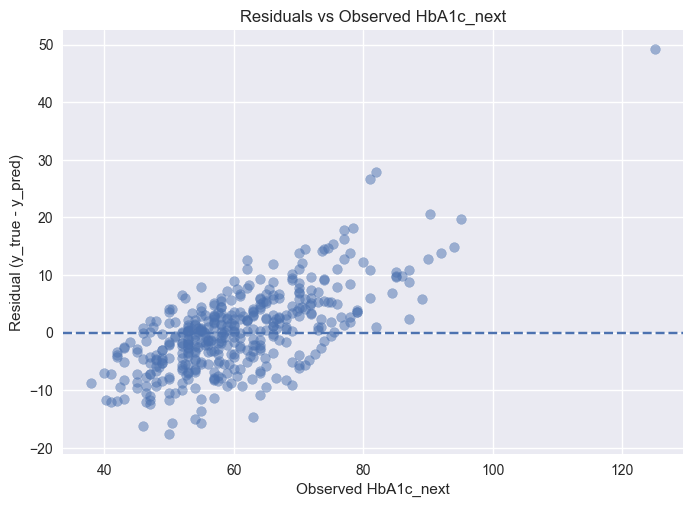

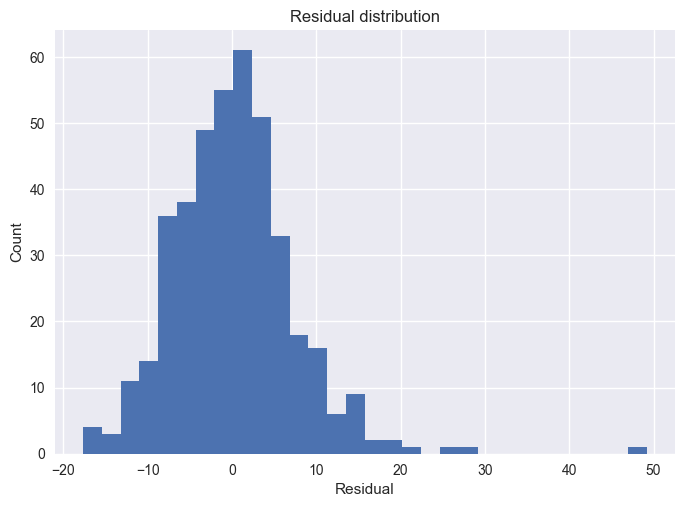

In [142]:
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Observed HbA1c_next")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Observed HbA1c_next")
plt.show()

plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual distribution")
plt.show()


Preparing data for SHAP...
Fitting SHAP TreeExplainer on trained RandomForest model...
Computing SHAP values for TEST set...


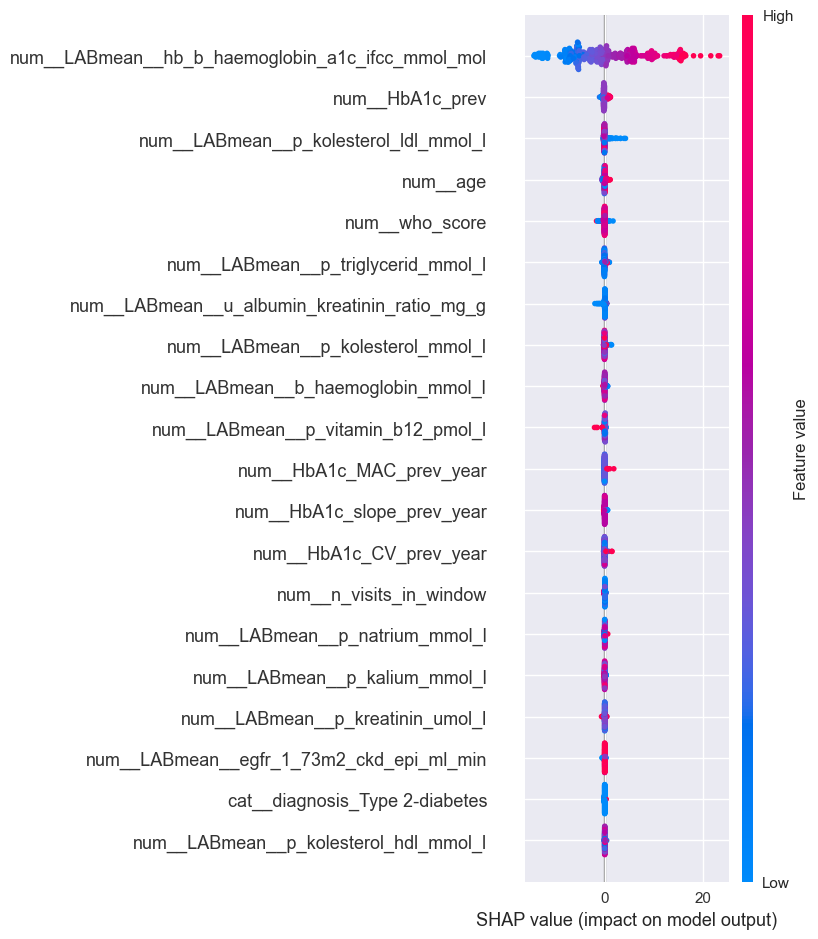

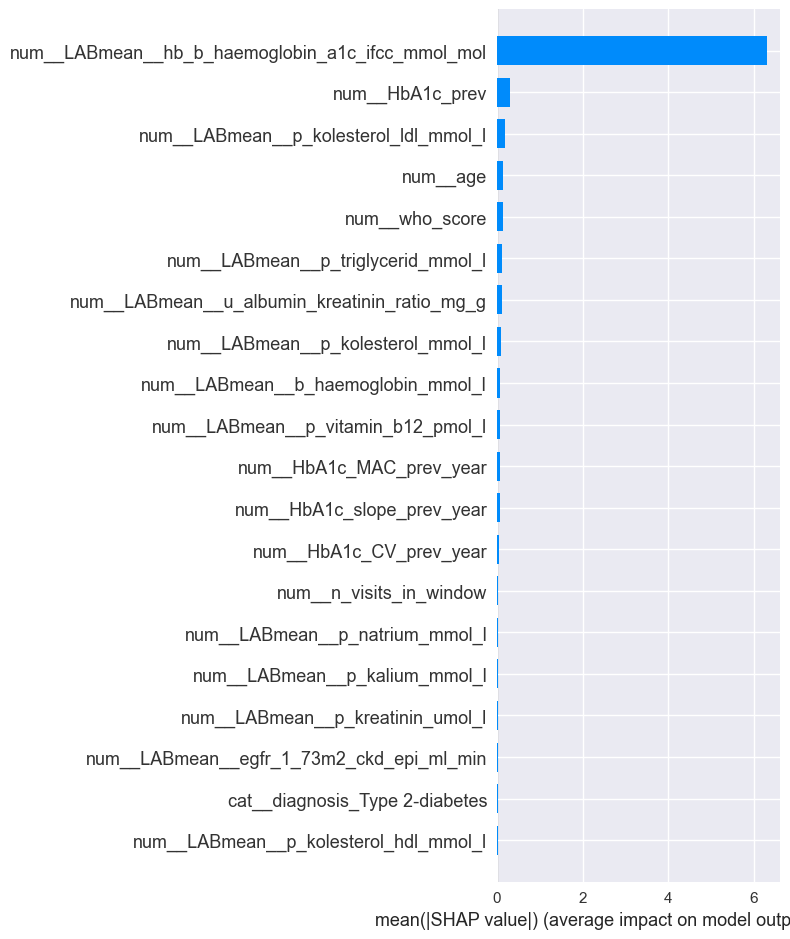

In [143]:
import shap
shap.initjs()

# =========================
# SHAP feature importance
# =========================

print("\nPreparing data for SHAP...")

preprocessor = model_pipe.named_steps["preprocess"]
rf_trained = model_pipe.named_steps["model"]

X_train_trans = preprocessor.transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feature_{i}" for i in range(X_train_trans.shape[1])]

print("Fitting SHAP TreeExplainer on trained RandomForest model...")
explainer = shap.TreeExplainer(rf_trained)

print("Computing SHAP values for TEST set...")
shap_values = explainer(X_test_trans)

shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names, plot_type="bar")



In [144]:
hba1c_features = [
    "HbA1c_prev",
    "LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol",
]

X_train_hba1c = X_train[hba1c_features]
X_test_hba1c  = X_test[hba1c_features]

pre_hba1c = ColumnTransformer(
    transformers=[("num", numeric_transformer, hba1c_features)],
    remainder="drop",
)

pipe_hba1c = Pipeline(steps=[
    ("preprocess", pre_hba1c),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
    )),
])


pipe_hba1c.fit(X_train_hba1c, y_train)
y_pred_hba1c = pipe_hba1c.predict(X_test_hba1c)

rmse_hba1c = np.sqrt(mean_squared_error(y_test, y_pred_hba1c))
mae_hba1c  = mean_absolute_error(y_test, y_pred_hba1c)
r2_hba1c   = r2_score(y_test, y_pred_hba1c)

print("\n--- MODEL KUN MED HbA1c-FEATURES ---")
print(f"RMSE: {rmse_hba1c:.2f}")
print(f"MAE : {mae_hba1c:.2f}")
print(f"R^2 : {r2_hba1c:.3f}")



--- MODEL KUN MED HbA1c-FEATURES ---
RMSE: 7.77
MAE : 5.74
R^2 : 0.505


In [145]:
hba1c_cols = [
    "HbA1c_prev",
    "LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol",
    "HbA1c_slope_prev_year",
    "HbA1c_CV_prev_year",
    "HbA1c_MAC_prev_year",
]

numerical_no_hba1c = [c for c in numerical_cols if c not in hba1c_cols]

pre_no_hba1c = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_no_hba1c),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

pipe_no_hba1c = Pipeline(steps=[
    ("preprocess", pre_no_hba1c),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
    )),
])

pipe_no_hba1c.fit(X_train, y_train)
y_pred_no_hba1c = pipe_no_hba1c.predict(X_test)

rmse_no = np.sqrt(mean_squared_error(y_test, y_pred_no_hba1c))
mae_no  = mean_absolute_error(y_test, y_pred_no_hba1c)
r2_no   = r2_score(y_test, y_pred_no_hba1c)

print("\n--- MODEL UDEN HbA1c-FEATURES ---")
print(f"RMSE: {rmse_no:.2f}")
print(f"MAE : {mae_no:.2f}")
print(f"R^2 : {r2_no:.3f}")



--- MODEL UDEN HbA1c-FEATURES ---
RMSE: 11.15
MAE : 8.63
R^2 : -0.017
